In [106]:

from scipy import optimize
from typing import Optional

from plot_utils import plot_bond, plot_bonds, BondCharacteristics

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Chapter 1,2: Bond Math and Interest Rate Risk

**From Donald J. Smith's ***Bond Math*** Textbook**


- Measure to estimate the sensitivity of bond price to changes in market rates/yields
  - Yield Duration: sensitivity of price to YTM
  - Yield Convexity: second order effect of the change in YTM
  - Curve Duration/Convexity: The sensitivity of the bond price to a shift in the benchmark Treasury yield curve
- Higher Duration doesn't always mean higher sensitivity!


#### YIELD DURATION AND CONVEXITY RELATIONSHIPS:
- Relationship between a change in the yield-to-maturity and change in bond price:

$$MV = \frac{PMT}{(1+y)^{1-t/T}} + \frac{PMT}{(1+y)^{2-t/T}} + ... + \frac{PMT}{(1+y)^{N-t/T}}$$
  
- 
  - PMC: periodic coupon payments
  - FV: principle
  - settlement date is t days
  - T-day period
  - N periods to maturity

<br>

- Yield Duration and Yield Convexity are estimations for change in market value
  - change in market value $d{Mv}$ caused by an instantaneous change in the yield to maturity per period $d{y}$
  - use _Taylor series expanison_ (first two terms are fine) assuming that the basic relationship between ytm and price is continuous and differentiables (no exotic option)

$$ \\d{MV} \approx (\frac{\partial{MV}}{\partial{y}} \times d{y}) + (\frac{1}{2} + \frac{\partial^2{MV}}{\partial^2{y}} \times (d{y})^2) $$

- 
  - the change in market value is estimated by the first partial derivative of the bond pricing formula times the change in the yield plus one‐half of the second partial derivative times the change in the yield squared.
  - first term: essence of yield duration
  - second term: essence of yield convexity
  - loosely >> change in bond price = duration bias + convexity bias

  <br>
  
$$ Macaulay\;Duration = - \frac{\partial{MV}}{\partial{y}} \times \frac{1 + y}{MV} $$

-
  - From Drederick Macaulay, a Canadian economist; derived in his study of U.S. railroad bond yields and stock prices between 1857 and 1936. 
  - minus sign signifies that duration will be a position number since its the first derivative of the inverse relationship between yields and prices

  <br>

$$ Modified\;Duration = - \frac{\partial{MV}}{\partial{y}} \times \frac{1}{MV} = \frac{Macaulay\;Duration}{1 + y}$$

$$ Money\;Duration \; (DV01\;or\; Dollar\;Duration) = \frac{\partial{MV}}{\partial{y}} = Modified\;Duration \times MV $$ 

- 
  - modified duration relates directly to the percentage change in the market value of the bond (used in practice)
  - DV01 used to estimate the change in value in terms of money, usually for a certain amount of par value

  <br>

$$ Convexity = \frac{\partial^2{MV}}{\partial^2{y}} \times \frac{1}{MV} $$  
$$ Money\;Convexity\;(Dollar\;Convexity) = \frac{\partial^2{MV}}{\partial^2{y}} = Convexity \times MV$$  


#### DERIVATION OF THE RELATIONSHIP BETWEEN YTM AND MARKET VALUE OF A BOND:

$\mathrm{d}^2$
$d$


In [52]:
def calc_bond_price_from_ytm(
    ytm: float,
    coupon: float,
    years_to_maturity: float,
    freq: int = 2,
    face_amount: float = 100.0,
    calc_dirty=False,
) -> float:
    ytm = ytm / 100  
    coupon = coupon / 100  
    bond_price = 0.0

    full_periods = int(years_to_maturity * freq)
    coupon_payment = face_amount * (coupon / freq)
    y_div_frq = ytm / freq

    for i in range(1, full_periods + 1):
        bond_price += coupon_payment / ((1 + y_div_frq) ** i)

    bond_price += face_amount / ((1 + y_div_frq) ** full_periods)
    
    if calc_dirty:
        fractional = years_to_maturity % 1
        coupon_per_period = coupon / freq
        accrued_rate = coupon_per_period * ((1 - fractional) / ((1 - fractional) * freq)) 
        accrued_interest = accrued_rate * face_amount
        return bond_price + accrued_interest 
    
    return bond_price


def calc_bond_ytm_from_price(
    curr_bond_price: float,
    face_amount: float,
    coupon: float,
    years_to_maturity: int,
    freq: int = 2,
    estimate: float = 0.05,
) -> float:
    get_yield = (
        lambda curr_yield: calc_bond_price_from_ytm(
            coupon=coupon,
            face_amount=face_amount,
            ytm=curr_yield,
            years_to_maturity=years_to_maturity,
            freq=freq,
        )
        - curr_bond_price
    )
    return optimize.newton(get_yield, estimate)

In [53]:
def calc_bond_duration(
    ytm: float,
    coupon: float,
    years_to_maturity: int,
    curr_bond_price: Optional[float] = None,
    face_amount: float = 100,
    freq: int = 2,
    modified=False,
    calc_dirty=False,
):
    bond_price = curr_bond_price or calc_bond_price_from_ytm(
        ytm=ytm,
        coupon=coupon,
        years_to_maturity=years_to_maturity,
        freq=freq,
        face_amount=face_amount,
        calc_dirty=calc_dirty,
    )

    ytm /= 100
    coupon_rate = coupon / 100
    coupon_payment = coupon_rate * face_amount
    n = int(years_to_maturity * freq)
    y = ytm / freq

    duration = 0
    for t in range(1, n + 1):
        duration += (t * coupon_payment / freq) / ((1 + y) ** t)
    duration += (n * face_amount) / ((1 + y) ** n)
    duration = (duration / bond_price) / freq
    duration = duration / (1 + y) if modified else duration

    return (duration, bond_price)

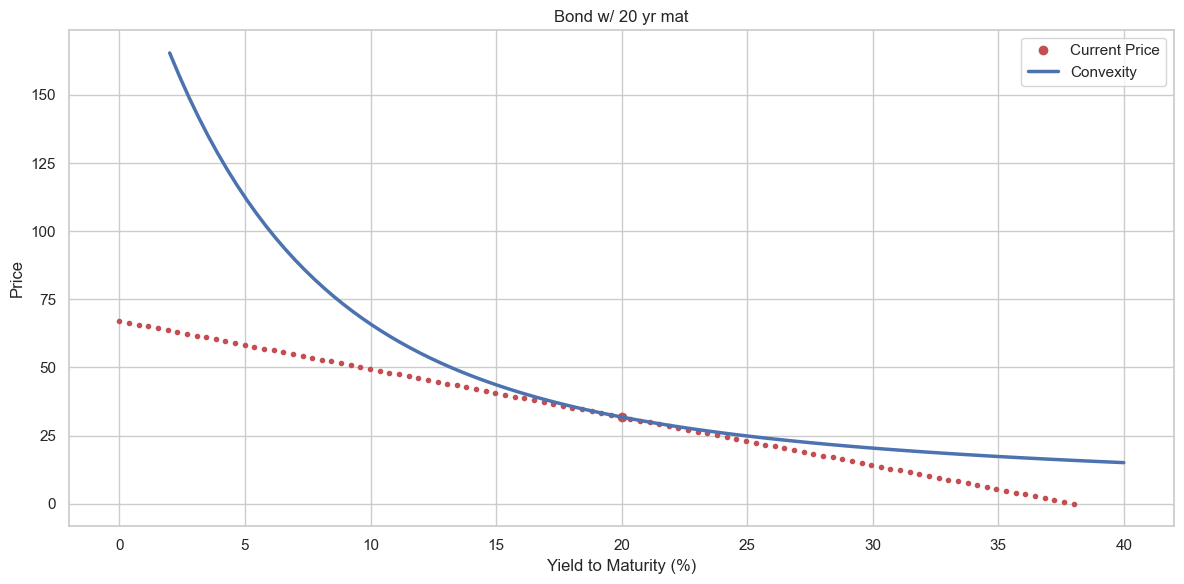

In [112]:
plot_bond(
    ytm=20,
    coupon=6,
    years_to_maturity=20,
    freq=1,
    face_amount=100,
    modified=True,
    calc_dirty=False,
    plot_title="Bond w/ 20 yr mat",
    calc_bond_duration=calc_bond_duration,
    calc_bond_price_from_ytm=calc_bond_price_from_ytm,
)

In [105]:
calc_bond_price_from_ytm(ytm=25, coupon=10, years_to_maturity=3, freq=1, face_amount=100, calc_dirty=False)

70.72

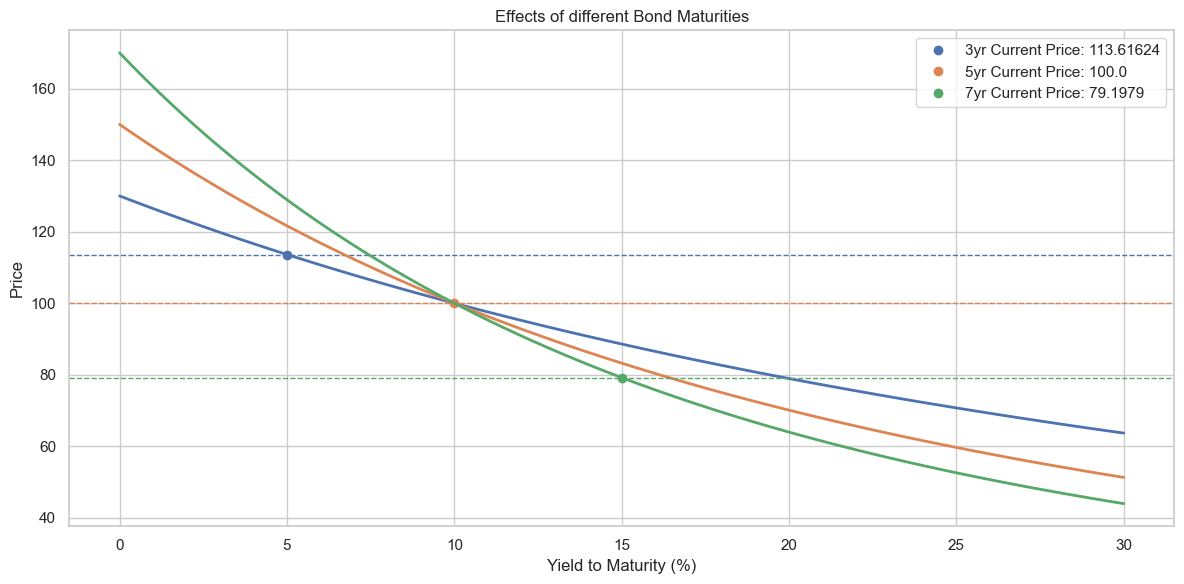

In [111]:
bonds_list = [
    # BondCharacteristics(ytm=20, coupon=6, years_to_maturity=2, freq=1, face_amount=100, label="2yr", calc_dirty=False),
    BondCharacteristics(ytm=5, coupon=10, years_to_maturity=3, freq=1, face_amount=100, label="3yr", calc_dirty=False),
    BondCharacteristics(ytm=10, coupon=10, years_to_maturity=5, freq=1, face_amount=100, label="5yr", calc_dirty=False),
    BondCharacteristics(ytm=15, coupon=10, years_to_maturity=7, freq=1, face_amount=100, label="7yr", calc_dirty=False),
    # BondCharacteristics(ytm=20, coupon=6, years_to_maturity=10, freq=1, face_amount=100, label="10yr", calc_dirty=False),
    # BondCharacteristics(ytm=20, coupon=6, years_to_maturity=20, freq=1, face_amount=100, label="20yr", calc_dirty=False),
    # BondCharacteristics(ytm=20, coupon=6, years_to_maturity=30, freq=1, face_amount=100, label="30yr", calc_dirty=False)
]

plot_bonds(
    bonds_list,
    modified_duration=True,
    calc_bond_duration=calc_bond_duration,
    calc_bond_price_from_ytm=calc_bond_price_from_ytm,
    plot_title="Effects of different Bond Maturities",
    plot_current_pricing=True,
    plot_current_pricing_line=True,
    plot_duration=False,
    plot_convexity=True,
    verbose=False,
    x_range=[0, 30]
)